In [1]:
import datetime
import time
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

In [2]:
!pip install transformers

     |████████████████████████████████| 1.3MB 13.1MB/s 
     |████████████████████████████████| 890kB 58.4MB/s 
     |████████████████████████████████| 2.9MB 50.3MB/s 
     |████████████████████████████████| 1.1MB 48.8MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=542da2330482bed4f889a6d8c7720212d8fda75fc19540c132d231812c1942af
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [3]:
if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [4]:
#df = pd.read_csv('./atis_intents.csv', delimiter=',', header=None)
df_train = pd.read_csv('./atis_intents_train.csv', delimiter=',', header=None)
df_test = pd.read_csv('./atis_intents_test.csv', delimiter=',', header=None)
#df.columns = ['class', 'message']
df_train.columns = ['class', 'message']
df_test.columns = ['class', 'message']

In [5]:
df_train.groupby("class").count()

,message
class,
atis_abbreviation,147
atis_aircraft,81
atis_airfare,423
atis_airline,157
atis_flight,3666
atis_flight_time,54
atis_ground_service,255
atis_quantity,51


In [6]:
df_test.groupby("class").count()

,message
class,
atis_abbreviation,33
atis_aircraft,9
atis_airfare,48
atis_airline,38
atis_flight,632
atis_flight_time,1
atis_ground_service,36
atis_quantity,3


In [7]:
def train_validation_split(data, shot_number):
    train = data.groupby('class').head(shot_number)
    validation = data[~data.isin(train)].dropna()
    return train, validation

In [8]:
def add_int_classes(data):
    new_column = pd.factorize(data['class'])
    data['int_labels'] = new_column[0]
    return data

In [39]:
from transformers import BertTokenizer

print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


In [40]:
def get_input_ids_and_att_mask(sentences):
    input_ids = []
    for sent in sentences:
        encoded_sent = tokenizer.encode(sent, add_special_tokens=True)
        input_ids.append(encoded_sent)
    print('Original: ', sentences[0])
    print('Token IDs:', input_ids[0])

    from keras.preprocessing.sequence import pad_sequences
    MAX_LEN = 32
    input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long",
                              value=0, truncating="post", padding="post")
    attention_masks = []
    for sent in input_ids:
        att_mask = [int(token_id > 0) for token_id in sent]
        attention_masks.append(att_mask)
    return input_ids, attention_masks


In [10]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [11]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    elapsed_rounded = int(round((elapsed)))
    
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [56]:
def train_inner(train_dataloader, validation_dataloader):
    from transformers import BertForSequenceClassification, AdamW

    model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                          num_labels=8,
                                                          output_attentions=False,
                                                          output_hidden_states=False,
                                                          )
    model.cuda()

    optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)

    from transformers import get_linear_schedule_with_warmup

    epochs = 8
    total_steps = len(train_dataloader) * epochs

    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0,  # Default value in run_glue.py
                                                num_training_steps=total_steps)
    
    import random

    seed_val = 42

    random.seed(seed_val)
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)
    torch.cuda.manual_seed_all(seed_val)
    loss_values = []

    # For each epoch...
    for epoch_i in range(0, epochs):

        print("")
        print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
        print('Training...')

        t0 = time.time()

        total_loss = 0

        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):

            # Progress update every 40 batches.
            if step % 40 == 0 and not step == 0:
                elapsed = format_time(time.time() - t0)

                # Report progress.
                print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step,
                                                                            len(train_dataloader),
                                                                            elapsed))

            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)

            model.zero_grad()

            outputs = model(b_input_ids,
                            token_type_ids=None,
                            attention_mask=b_input_mask,
                            labels=b_labels)

            loss = outputs[0]
            total_loss += loss.item()

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            optimizer.step()

            scheduler.step()

        avg_train_loss = total_loss / len(train_dataloader)

        loss_values.append(avg_train_loss)

        print("")
        print("  Average training loss: {0:.2f}".format(avg_train_loss))
        print("  Training epoch took: {:}".format(format_time(time.time() - t0)))

        print("")
        print("Running Validation...")

        t0 = time.time()

        model.eval()

        # Tracking variables
        eval_loss, eval_accuracy = 0, 0
        nb_eval_steps, nb_eval_examples = 0, 0

        # Evaluate data for one epoch
        for batch in validation_dataloader:
            # Add batch to GPU
            batch = tuple(t.to(device) for t in batch)

            # Unpack the inputs from our dataloader
            b_input_ids, b_input_mask, b_labels = batch

            with torch.no_grad():
                outputs = model(b_input_ids,
                                token_type_ids=None,
                                attention_mask=b_input_mask)

            logits = outputs[0]

            logits = logits.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()

            tmp_eval_accuracy = flat_accuracy(logits, label_ids)

            eval_accuracy += tmp_eval_accuracy

            nb_eval_steps += 1

        print("  Accuracy: {0:.2f}".format(eval_accuracy / nb_eval_steps))
        print("  Validation took: {:}".format(format_time(time.time() - t0)))

    print("")
    print("Training complete!")
    return model

In [66]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

In [67]:
def train_model(data, shot_number):
    df_train_split, df_validation_split = train_validation_split(data, shot_number)
    df_train_split = add_int_classes(df_train_split)
    df_validation_split = add_int_classes(df_validation_split)

    X_train, y_train = df_train_split['message'], df_train_split['int_labels']
    X_validation, y_validation = df_validation_split['message'], df_validation_split['int_labels']

    train_labels = df_train_split.loc[:, 'int_labels'].values
    train_sentences = df_train_split.loc[:, 'message'].values
    validation_labels = df_validation_split.loc[:, 'int_labels'].values
    validation_sentences = df_validation_split.loc[:, 'message'].values

    train_inputs, train_masks = get_input_ids_and_att_mask(train_sentences)
    validation_inputs, validation_masks = get_input_ids_and_att_mask(validation_sentences)

    train_inputs = torch.tensor(train_inputs)
    validation_inputs = torch.tensor(validation_inputs)

    train_labels = torch.tensor(train_labels)
    validation_labels = torch.tensor(validation_labels)

    train_masks = torch.tensor(train_masks)
    validation_masks = torch.tensor(validation_masks)

    batch_size = 16

    train_data = TensorDataset(train_inputs, train_masks, train_labels)
    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

    validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
    validation_sampler = SequentialSampler(validation_data)
    validation_dataloader = DataLoader(validation_data, sampler=validation_sampler,
                                       batch_size=batch_size)

    model = train_inner(train_dataloader, validation_dataloader)
    return model

In [74]:
def test_model(df_test, model):
    df_test = add_int_classes(df_test)

    X_test, y_test = df_test['message'], df_test['int_labels']

    test_inputs, test_masks = get_input_ids_and_att_mask(X_test.values)

    prediction_inputs = torch.tensor(test_inputs)
    prediction_masks = torch.tensor(test_masks)
    prediction_labels = torch.tensor(y_test)

    batch_size = 16

    prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
    prediction_sampler = SequentialSampler(prediction_data)
    prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler,
                                       batch_size=batch_size)
    # Prediction on test set

    print('Predicting labels for {:,} test sentences...'.format(len(prediction_inputs)))

    # Put model in evaluation mode
    model.eval()

    # Tracking variables 
    predictions, true_labels = [], []

    # Predict 
    for batch in prediction_dataloader:
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)

        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch

        # Telling the model not to compute or store gradients, saving memory and 
        # speeding up prediction
        with torch.no_grad():
            # Forward pass, calculate logit predictions
            outputs = model(b_input_ids, token_type_ids=None,
                            attention_mask=b_input_mask)

        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Store predictions and true labels
        predict_label = np.argmax(logits, axis=1)
        predictions.append(predict_label)
        true_labels.append(label_ids)

    flat_predictions = [item for sublist in predictions for item in sublist]
    flat_true_labels = [item for sublist in true_labels for item in sublist]

    from sklearn.metrics import matthews_corrcoef, f1_score, recall_score, precision_score
    f1 = f1_score(flat_true_labels, flat_predictions, average="macro")
    recall = recall_score(flat_true_labels, flat_predictions, average="macro")
    precision = precision_score(flat_true_labels, flat_predictions, average="macro")
    matt_corr = matthews_corrcoef(flat_true_labels, flat_predictions)
    print("F1-Score: ", f1)
    print("Recall: ", recall)
    print("Precision: ", precision)
    print("MCC: ", matt_corr)
    return f1, recall, precision, matt_corr


In [75]:
def train_and_test(train, test, shot_number):
  model = train_model(train, shot_number)
  return test_model(test, model)

In [76]:
shot_1 = train_and_test(df_train, df_test, 1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Original:   i want to fly from boston at 838 am and arrive in denver at 1110 in the morning
Token IDs: [101, 1045, 2215, 2000, 4875, 2013, 3731, 2012, 6640, 2620, 2572, 1998, 7180, 1999, 7573, 2012, 11118, 2692, 1999, 1996, 2851, 102]
Original:   what flights are available from pittsburgh to baltimore on thursday morning
Token IDs: [101, 2054, 7599, 2024, 2800, 2013, 6278, 2000, 6222, 2006, 9432, 2851, 102]


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


======== Epoch 1 / 8 ========
Training...

  Average training loss: 2.16
  Training epoch took: 0:00:00

Running Validation...
  Accuracy: 0.06
  Validation took: 0:00:10

======== Epoch 2 / 8 ========
Training...

  Average training loss: 2.12
  Training epoch took: 0:00:00

Running Validation...
  Accuracy: 0.08
  Validation took: 0:00:10

======== Epoch 3 / 8 ========
Training...

  Average training loss: 1.95
  Training epoch took: 0:00:00

Running Validation...
  Accuracy: 0.09
  Validation took: 0:00:10

======== Epoch 4 / 8 ========
Training...

  Average training loss: 1.98
  Training epoch took: 0:00:00

Running Validation...
  Accuracy: 0.07
  Validation took: 0:00:10

======== Epoch 5 / 8 ========
Training...

  Average training loss: 1.91
  Training epoch took: 0:00:00

Running Validation...
  Accuracy: 0.08
  Validation took: 0:00:10

======== Epoch 6 / 8 ========
Training...

  Average training loss: 1.87
  Training epoch took: 0:00:00

Running Validation...
  Accuracy: 

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [77]:
shot_2 = train_and_test(df_train, df_test, 2)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Original:   i want to fly from boston at 838 am and arrive in denver at 1110 in the morning
Token IDs: [101, 1045, 2215, 2000, 4875, 2013, 3731, 2012, 6640, 2620, 2572, 1998, 7180, 1999, 7573, 2012, 11118, 2692, 1999, 1996, 2851, 102]
Original:   i need a flight tomorrow from columbus to minneapolis
Token IDs: [101, 1045, 2342, 1037, 3462, 4826, 2013, 8912, 2000, 11334, 102]


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


======== Epoch 1 / 8 ========
Training...

  Average training loss: 2.12
  Training epoch took: 0:00:00

Running Validation...
  Accuracy: 0.05
  Validation took: 0:00:09

======== Epoch 2 / 8 ========
Training...

  Average training loss: 2.12
  Training epoch took: 0:00:00

Running Validation...
  Accuracy: 0.10
  Validation took: 0:00:10

======== Epoch 3 / 8 ========
Training...

  Average training loss: 2.06
  Training epoch took: 0:00:00

Running Validation...
  Accuracy: 0.15
  Validation took: 0:00:10

======== Epoch 4 / 8 ========
Training...

  Average training loss: 1.95
  Training epoch took: 0:00:00

Running Validation...
  Accuracy: 0.16
  Validation took: 0:00:10

======== Epoch 5 / 8 ========
Training...

  Average training loss: 1.94
  Training epoch took: 0:00:00

Running Validation...
  Accuracy: 0.19
  Validation took: 0:00:10

======== Epoch 6 / 8 ========
Training...

  Average training loss: 1.90
  Training epoch took: 0:00:00

Running Validation...
  Accuracy: 

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [78]:
shot_5 = train_and_test(df_train, df_test, 5)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Original:   i want to fly from boston at 838 am and arrive in denver at 1110 in the morning
Token IDs: [101, 1045, 2215, 2000, 4875, 2013, 3731, 2012, 6640, 2620, 2572, 1998, 7180, 1999, 7573, 2012, 11118, 2692, 1999, 1996, 2851, 102]
Original:   show me the flights from dallas to san francisco
Token IDs: [101, 2265, 2033, 1996, 7599, 2013, 5759, 2000, 2624, 3799, 102]


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


======== Epoch 1 / 8 ========
Training...

  Average training loss: 2.14
  Training epoch took: 0:00:00

Running Validation...
  Accuracy: 0.06
  Validation took: 0:00:10

======== Epoch 2 / 8 ========
Training...

  Average training loss: 1.99
  Training epoch took: 0:00:00

Running Validation...
  Accuracy: 0.09
  Validation took: 0:00:10

======== Epoch 3 / 8 ========
Training...

  Average training loss: 1.97
  Training epoch took: 0:00:00

Running Validation...
  Accuracy: 0.06
  Validation took: 0:00:10

======== Epoch 4 / 8 ========
Training...

  Average training loss: 1.90
  Training epoch took: 0:00:00

Running Validation...
  Accuracy: 0.02
  Validation took: 0:00:10

======== Epoch 5 / 8 ========
Training...

  Average training loss: 1.88
  Training epoch took: 0:00:00

Running Validation...
  Accuracy: 0.03
  Validation took: 0:00:10

======== Epoch 6 / 8 ========
Training...

  Average training loss: 1.86
  Training epoch took: 0:00:00

Running Validation...
  Accuracy: 

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [79]:
shot_10 = train_and_test(df_train, df_test, 10)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Original:   i want to fly from boston at 838 am and arrive in denver at 1110 in the morning
Token IDs: [101, 1045, 2215, 2000, 4875, 2013, 3731, 2012, 6640, 2620, 2572, 1998, 7180, 1999, 7573, 2012, 11118, 2692, 1999, 1996, 2851, 102]
Original:   i need information on flights for tuesday leaving baltimore for dallas dallas to boston and boston to baltimore
Token IDs: [101, 1045, 2342, 2592, 2006, 7599, 2005, 9857, 2975, 6222, 2005, 5759, 5759, 2000, 3731, 1998, 3731, 2000, 6222, 102]


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


======== Epoch 1 / 8 ========
Training...

  Average training loss: 2.13
  Training epoch took: 0:00:01

Running Validation...
  Accuracy: 0.06
  Validation took: 0:00:10

======== Epoch 2 / 8 ========
Training...

  Average training loss: 2.03
  Training epoch took: 0:00:01

Running Validation...
  Accuracy: 0.10
  Validation took: 0:00:10

======== Epoch 3 / 8 ========
Training...

  Average training loss: 1.89
  Training epoch took: 0:00:01

Running Validation...
  Accuracy: 0.19
  Validation took: 0:00:10

======== Epoch 4 / 8 ========
Training...

  Average training loss: 1.90
  Training epoch took: 0:00:01

Running Validation...
  Accuracy: 0.21
  Validation took: 0:00:10

======== Epoch 5 / 8 ========
Training...

  Average training loss: 1.77
  Training epoch took: 0:00:01

Running Validation...
  Accuracy: 0.19
  Validation took: 0:00:10

======== Epoch 6 / 8 ========
Training...

  Average training loss: 1.71
  Training epoch took: 0:00:01

Running Validation...
  Accuracy: 

In [80]:
shot_20 = train_and_test(df_train, df_test, 20)

Original:   i want to fly from boston at 838 am and arrive in denver at 1110 in the morning
Token IDs: [101, 1045, 2215, 2000, 4875, 2013, 3731, 2012, 6640, 2620, 2572, 1998, 7180, 1999, 7573, 2012, 11118, 2692, 1999, 1996, 2851, 102]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Original:   please find a flight on delta from philadelphia to san francisco and give me the flight numbers
Token IDs: [101, 3531, 2424, 1037, 3462, 2006, 7160, 2013, 4407, 2000, 2624, 3799, 1998, 2507, 2033, 1996, 3462, 3616, 102]


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


======== Epoch 1 / 8 ========
Training...

  Average training loss: 2.09
  Training epoch took: 0:00:01

Running Validation...
  Accuracy: 0.39
  Validation took: 0:00:09

======== Epoch 2 / 8 ========
Training...

  Average training loss: 1.91
  Training epoch took: 0:00:01

Running Validation...
  Accuracy: 0.29
  Validation took: 0:00:10

======== Epoch 3 / 8 ========
Training...

  Average training loss: 1.77
  Training epoch took: 0:00:01

Running Validation...
  Accuracy: 0.28
  Validation took: 0:00:10

======== Epoch 4 / 8 ========
Training...

  Average training loss: 1.61
  Training epoch took: 0:00:01

Running Validation...
  Accuracy: 0.26
  Validation took: 0:00:10

======== Epoch 5 / 8 ========
Training...

  Average training loss: 1.50
  Training epoch took: 0:00:01

Running Validation...
  Accuracy: 0.29
  Validation took: 0:00:09

======== Epoch 6 / 8 ========
Training...

  Average training loss: 1.38
  Training epoch took: 0:00:01

Running Validation...
  Accuracy: 

In [88]:
shots_res = [shot_1, shot_2, shot_5, shot_10, shot_20]
shots = [1, 2, 5, 10, 20]

In [89]:
f_scores = [elem[0] for elem in shots_res]
recalls = [elem[1] for elem in shots_res]
precissions = [elem[2] for elem in shots_res]
mccs = [elem[3] for elem in shots_res]

Text(0.5, 1.0, 'MCC')

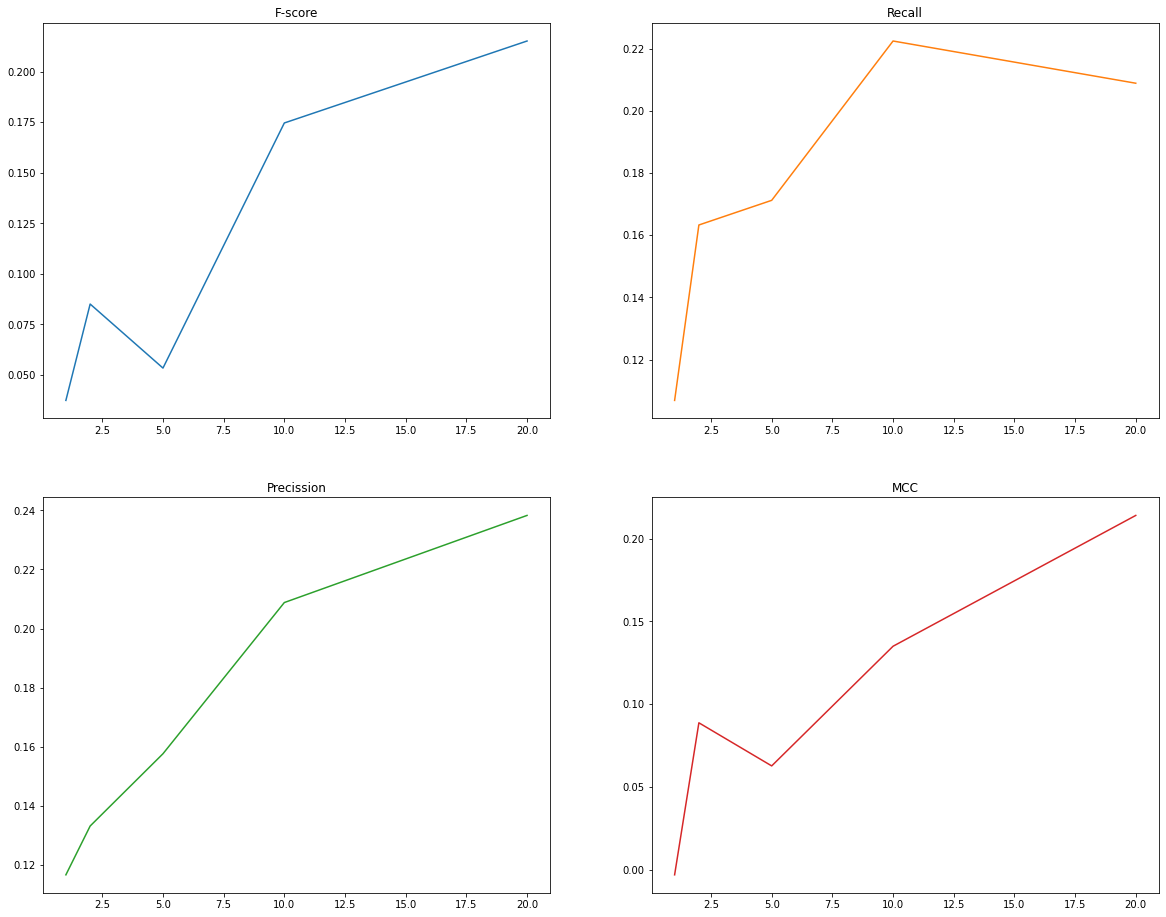

In [94]:
fig, axs = plt.subplots(2, 2, figsize=(20,16))
axs[0, 0].plot(shots, f_scores)
axs[0, 0].set_title('F-score')
axs[0, 1].plot(shots, recalls, 'tab:orange')
axs[0, 1].set_title('Recall')
axs[1, 0].plot(shots, precissions, 'tab:green')
axs[1, 0].set_title('Precission')
axs[1, 1].plot(shots, mccs, 'tab:red')
axs[1, 1].set_title('MCC')